In [1]:
# Use QiskitRuntimeService from qiskit-ibm-runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from os import getenv
# Get IBM Quantum account from environment variable
ibm_token = getenv("ibm_token")
ibm_instance = getenv("QISKIT_IBM_INSTANCE")
QiskitRuntimeService.save_account(
    token=ibm_token, 
    channel="ibm_quantum_platform", 
    overwrite=True, region='us-east',
    instance=ibm_instance,
    plans_preference=["Open"]
)

In [2]:
# Instantiate the QiskitRuntimeService
try:
    # Initialize service with token. Specify channel if needed (e.g., 'ibm_cloud', 'ibm_quantum').
    service = QiskitRuntimeService()
    print("QiskitRuntimeService initialized successfully.")
except Exception as e:
    print(f"Failed to initialize QiskitRuntimeService: {e}")
    raise

QiskitRuntimeService initialized successfully.


In [3]:
available_backends = service.backends()
show_backend = print(available_backends)
choose = input("Enter the name of the backend you want to choose : ")

backend = next((backend for backend in available_backends if str(backend) == choose), None)
if backend is None:
    print("No backend found with the name:", choose)

[<IBMBackend('ibm_torino')>, <IBMBackend('ibm_brisbane')>]


In [4]:
if backend is not None and backend.configuration().simulator is False:
    print(f"Successfully connected to the selected QPU backend: {backend}")
else:
    print("Failed to connect to the selected QPU backend or the backend is a simulator.")

Successfully connected to the selected QPU backend: <IBMBackend('ibm_torino')>


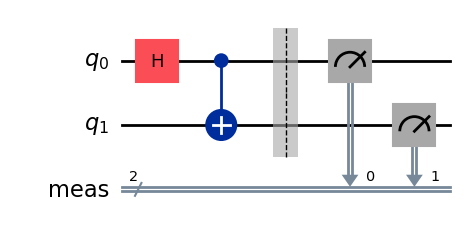

In [5]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0) # Add a Hadamard gate to qubit 0
qc.cx(0, 1) # Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.measure_all() # Measure all qubits

''' Return a drawing of the circuit using MatPlotLib ("mpl"). This is the last line of the cell, 
so the drawing appears in the cell output. Remove the "mpl" argument to get a text drawing. '''
qc.draw('mpl')

In [6]:
# import the required libraries
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

In [7]:
# Set up six different observables.
observables_labels = ["ZZ", "ZI", "IZ", "XX", "XI"]
observables = [SparsePauliOp(label) for label in observables_labels]

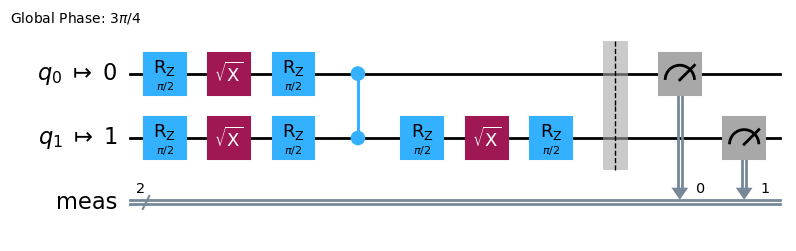

In [8]:
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
observables = [observable.apply_layout(isa_circuit.layout) for observable in observables]
isa_circuit.draw("mpl", idle_wires=False)

In [9]:
# construct the estimator instance we want to use
estimator = Estimator(mode=backend, options={"resilience_level": 1, "default_shots": 5000})


# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, observables)])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: d2ng4scg59ks73c7e4gg


In [10]:
# This is the result of the entire submission.  We submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]

<ErrorbarContainer object of 3 artists>

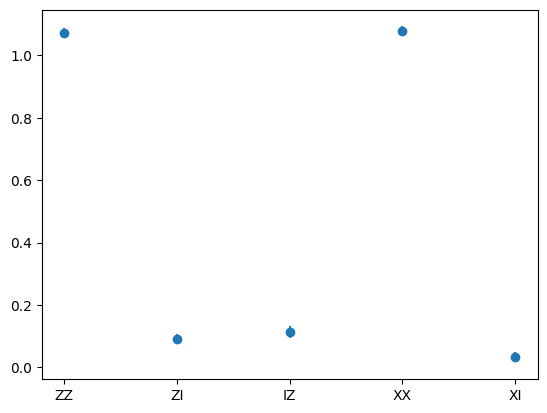

In [11]:
# Plot the result
 
from matplotlib import pyplot as plt
 
data = observables_labels
values = pub_result.data.evs
 
errors = pub_result.data.ensemble_standard_error
 
plt.errorbar(observables_labels, values, yerr=errors, fmt="o")

In [12]:
job11 = service.job(job.job_id())
job_result = job11.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: [1.07154073 0.09086505 0.1133227  1.07628206 0.03180277]
